# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from minisom import MiniSom

from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
np.random.seed(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/01c_minisom'

# Loading data

In [4]:
path_to_data = './../data/ftir_scaled_train.csv'
path_to_description = './../data/ftir_description.csv'

## Scaled spectra

In [5]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Data wrangling

In [7]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [8]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

In [9]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

# Clustering using *MiniSom*

## Base variables

In [10]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

In [11]:
FONT_SIZE_TITLE = 22
FONT_SIZE_XLABEL = 18
FONT_SIZE_YLABEL = 18
FONT_SIZE_XTICKS = 16
FONT_SIZE_YTICKS = 16

## Class for clustering

In [12]:
class SomStructureAnalysis:
    def __init__(self, data):
        if isinstance(data, pd.DataFrame):
            self.train_data = data.to_numpy()
            self.original_data = data
        else:
            self.train_data = np.array(data)
            self.original_data = pd.DataFrame(data)

    def fit_transform_som(self, shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=10_000, random_seed=42, verbose=True):
        estimator = MiniSom(
            x=shape[0], y=shape[1], input_len=self.train_data.shape[1],
            sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian',
            random_seed=random_seed
        )
        estimator.train_batch(self.train_data, num_iteration, verbose=verbose)

        winner_coordinates = np.array([estimator.winner(x) for x in self.train_data]).T
        predictions = np.ravel_multi_index(winner_coordinates, shape)

        data_with_predictions = self.original_data.copy()
        data_with_predictions['Prediction'] = predictions

        self.n_clusters = len(set(predictions))
        self.estimator = estimator
        self.predictions = predictions
        self.train_data_predictions = data_with_predictions.sort_values(by='Prediction')

        self.cluster_centers = self.train_data_predictions.groupby(['Prediction']).mean().to_numpy()

    def get_silhouette_score(self):
        if self.n_clusters < 2 or self.n_clusters >= len(self.train_data):
            return None  # Возвращаем None, если нельзя вычислить
        return silhouette_score(self.train_data, self.predictions)


    def get_metrics_visualization(self, max_n_clusters, ax, metric='silhouette', num_iteration=2_000, refit=False):
        shapes_arr = range(1, max_n_clusters + 1)
        metric_values, shape_values = [], []
        original_n_clusters = self.n_clusters

        for shape1 in tqdm(shapes_arr, desc=f'Computing {metric} values'):
            for shape2 in shapes_arr:
                if shape1 * shape2 >= 2 and shape1 * shape2 <= max_n_clusters:
                    self.fit_transform_som(shape=(shape1, shape2), num_iteration=num_iteration, verbose=False)
                    value = self.get_silhouette_score() if metric == 'silhouette' else None
                    metric_values.append(value)
                    shape_values.append(f'({shape1},{shape2})')

        sns.barplot(x=shape_values, y=metric_values, palette='viridis', ax=ax)
        
        ax.set_title('Зависимость silhouette score от сетки SOM', fontsize=FONT_SIZE_TITLE)
        
        ax.set_xlabel('Размер сетки', fontsize=FONT_SIZE_XLABEL)
        ax.set_ylabel('Silhouette score', fontsize=FONT_SIZE_YLABEL)
        
        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS-2, rotation=0)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)

        if not refit:
            self.fit_transform_som(shape=(1, original_n_clusters), num_iteration=num_iteration, verbose=False)

    def get_spectra_clusters_visualization(self, wavenumber, axes, color):
        data_with_labels = self.train_data_predictions
        n_clusters = self.n_clusters

        for cluster_id in range(n_clusters):
            ax = axes[cluster_id]

            temp_data = data_with_labels[data_with_labels['Prediction'] == cluster_id].iloc[:, :-1].to_numpy()
            temp_centroid = np.mean(temp_data, axis=0) if len(temp_data) > 0 else None

            if len(temp_data) == 0:
                ax.axis("off")
                continue

            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=3.5, color=color, alpha=1.0)

            if temp_centroid is not None:
                ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=4.0, color='black', alpha=0.7)

            ax.set_title(f'Кластер №{cluster_id+1}', fontsize=FONT_SIZE_TITLE-4, fontweight='bold')
            
            ax.set_xlabel('Волновое число, см$^{-1}$', fontsize=FONT_SIZE_XLABEL)
            ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL, rotation=0, labelpad=20)
            
            ax.set_xticks(np.linspace(1900, 800, 6))

            ax.set_xticks(np.linspace(1900, 800, 6))
            
            ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
            ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
            
            ax.invert_xaxis()

## Clustering & Visualization

In [13]:
max_n_clusters = 5

datasets = [
    ('$ОГ$', go_data, 'RoyalBlue', (2, 2)),
    ('$вОГ$', rgo_data, 'Goldenrod', (1, 2)),
    ('$ОГ_{диализ}$', god_data, 'SeaGreen', (1, 3))
]

predictions_lst = []

 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.8206322287817951


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  5.85it/s]


 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931189504


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  7.09it/s]


 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 1.6558428152252804


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  6.58it/s]


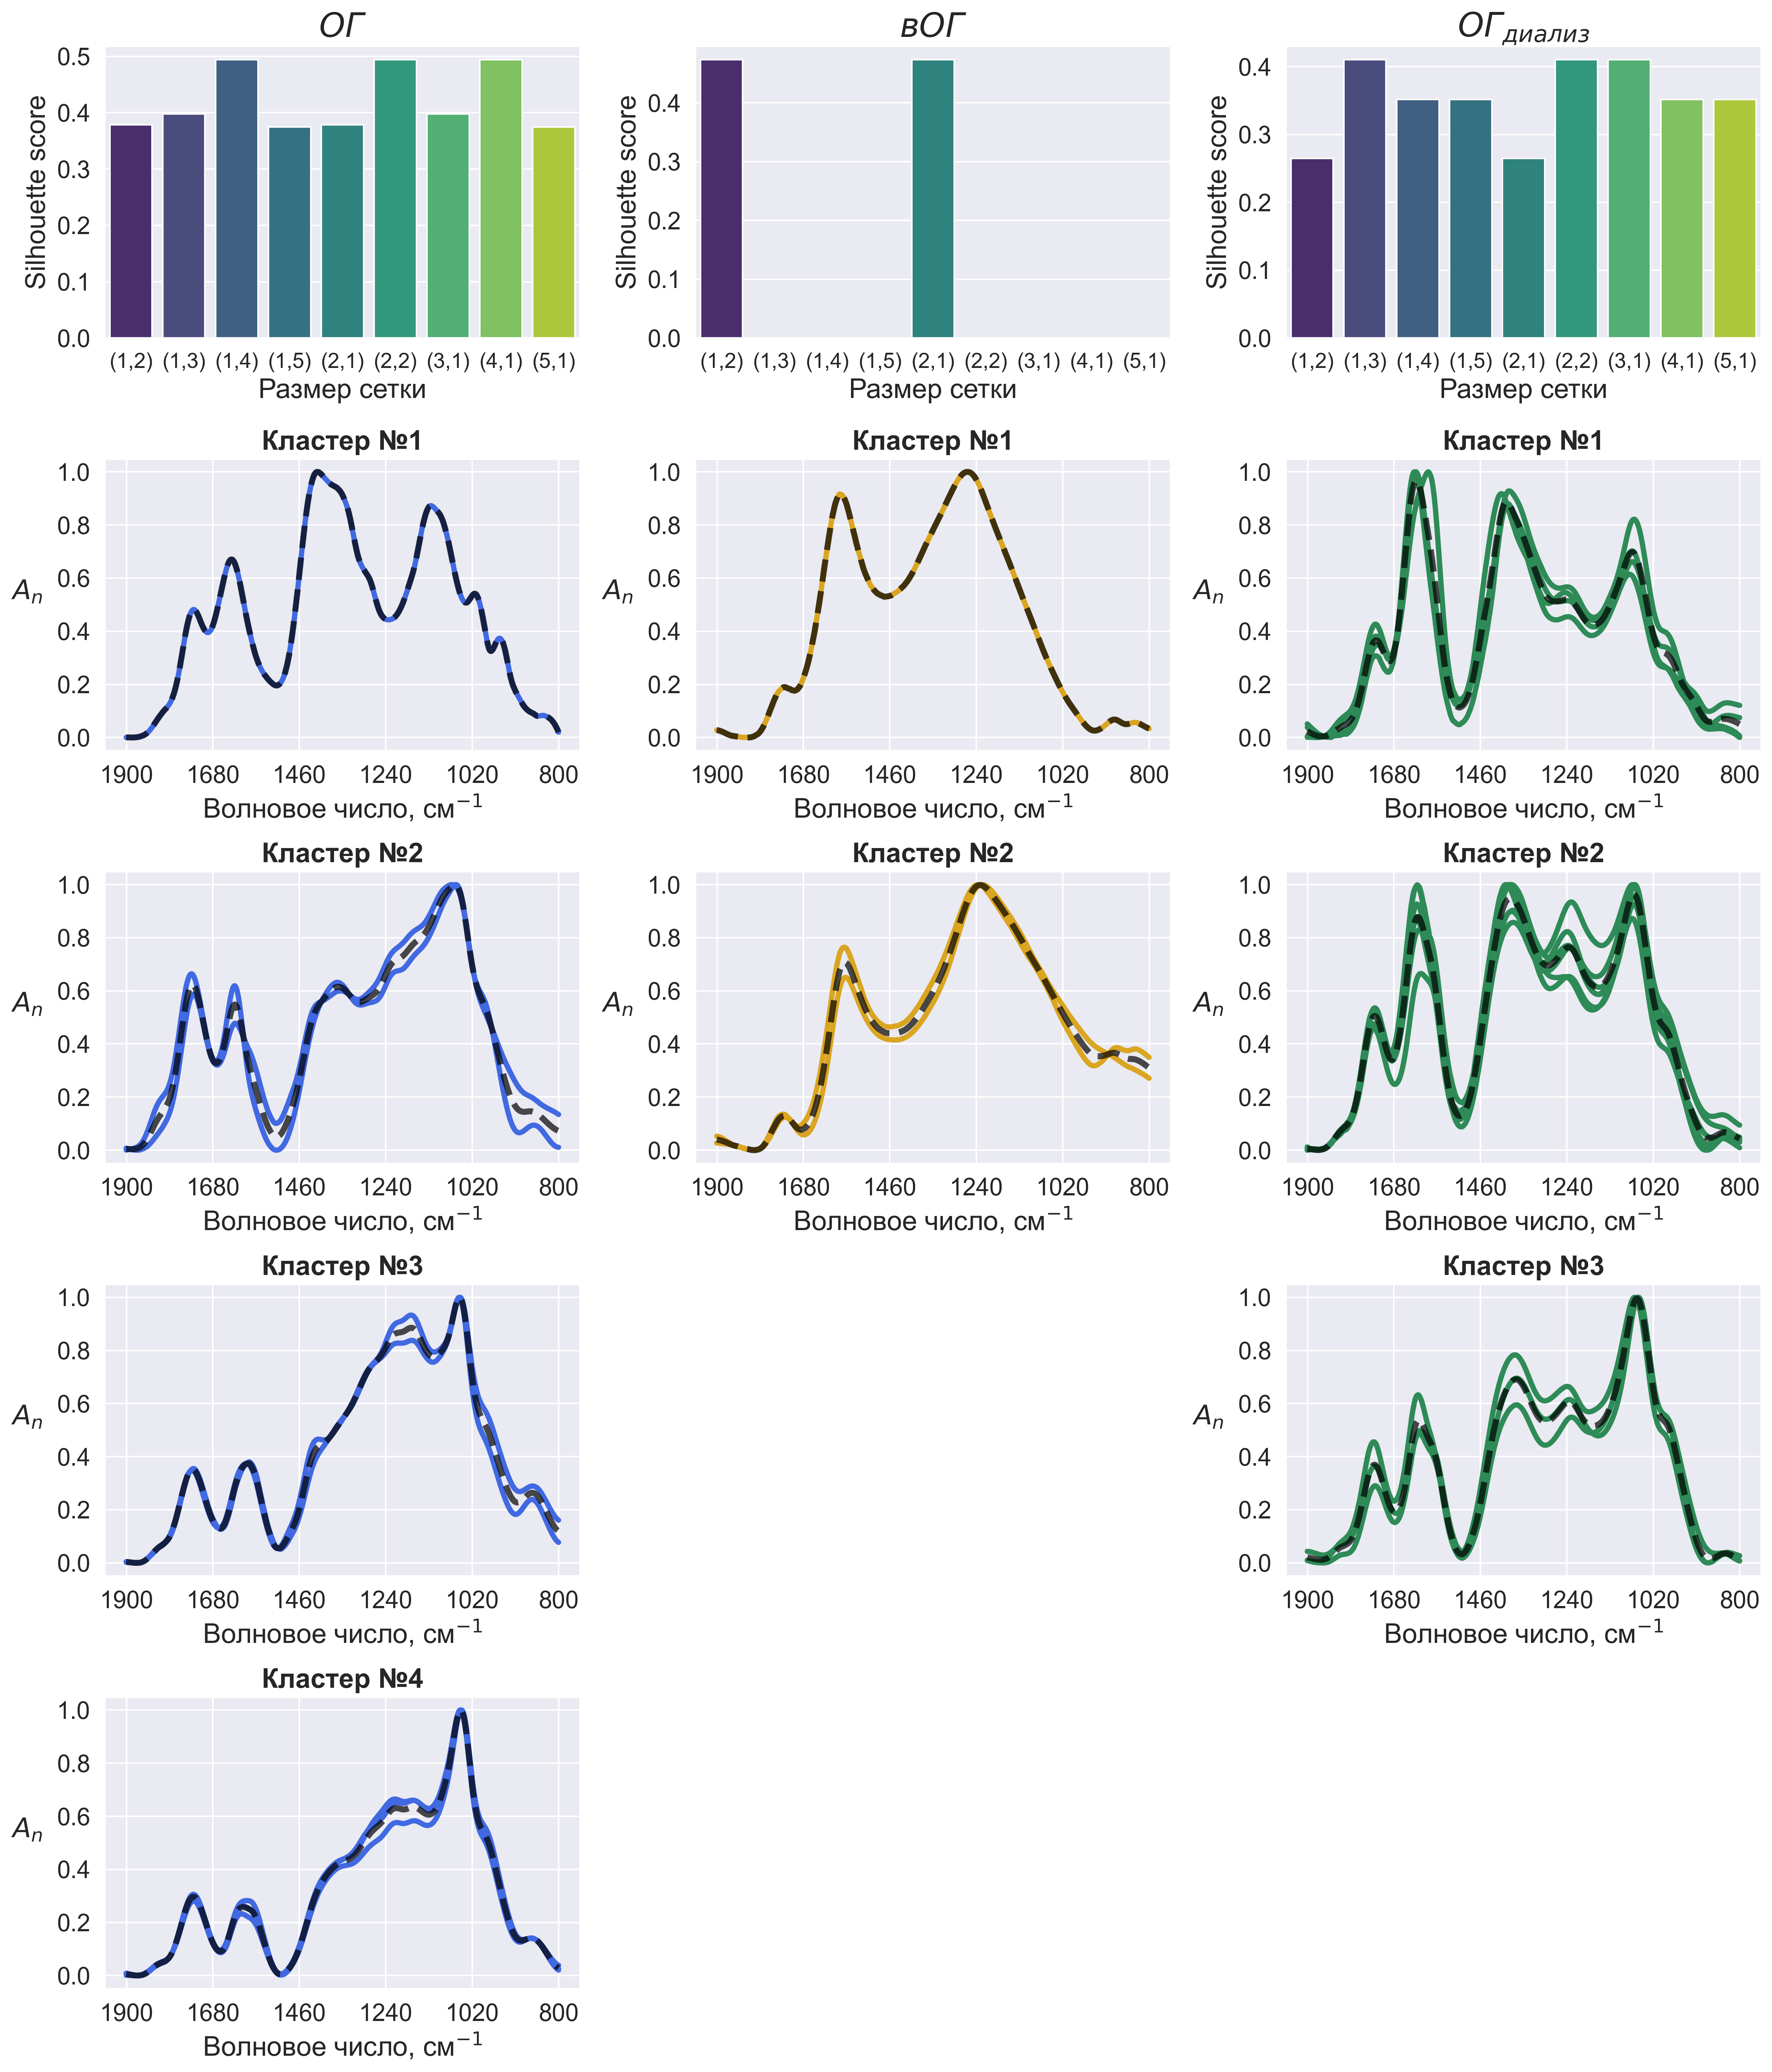

In [14]:
sns.set_theme()

max_clusters = max([d[3][0] * d[3][1] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(16.5, 3.85 * fig_rows), dpi=300, constrained_layout=True)

for i, (label, dataset, color, shape) in enumerate(datasets):
    analyzer = SomStructureAnalysis(dataset)

    analyzer.fit_transform_som(shape=shape, num_iteration=25_000)
    
    analyzer.get_metrics_visualization(max_n_clusters=max_n_clusters, ax=axes[0, i], refit=False)
    
    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE)
    axes[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    sub_axes = axes[1:analyzer.n_clusters+1, i]

    for i, ax in enumerate(sub_axes):
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
            
    analyzer.get_spectra_clusters_visualization(wavenumber=wavenumber, axes=sub_axes, color=color)

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3][0] * datasets[i][3][1] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig(f'{path_to_save}/clustering_results.png', dpi=600)

plt.show()

## Analytics of results

In [15]:
results_df = pd.DataFrame()

for predictions_df in predictions_lst:
    tmp_description_prediction_df = pd.merge(
        left=predictions_df['Prediction'],
        right=samples_description[['Type', 'Description']],
        left_index=True,
        right_index=True
    )

    results_df = pd.concat([results_df, tmp_description_prediction_df], axis=0)

results_df = results_df[['Type', 'Description', 'Prediction']].sort_values(by=['Type', 'Prediction', 'Description'])

results_df

,Type,Description,Prediction
2,$GO$,"HGO, 0.0116 г в 25 мл H2O",0
12,$GO$,"GO, USA, 0.1 г в 100 мл H2O",1
1,$GO$,"MFGO, разб. 1:20",1
3,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",2
13,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",2
9,$GO$,"GO, RusGraphene, 1.00 г в 250 мл H2O",3
11,$GO$,"GO, RusGraphene, 1.00 г в 250 мл H2O",3
8,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",3
30,$GO_{d}$,"Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М",0
24,$GO_{d}$,"Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М",0


## Adhoc visualization

In [16]:
max_n_clusters = 5

datasets = [
    ('$ОГ$', go_data, 'RoyalBlue', (2, 2)),
    ('$вОГ$', rgo_data, 'Goldenrod', (1, 2)),
    ('$ОГ_{диализ}$', god_data, 'SeaGreen', (1, 3))
]

predictions_lst = []

 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.8206322287817951


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  6.78it/s]


 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931189504


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  6.45it/s]


 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 1.6558428152252804


Computing silhouette values: 100%|████████████████| 5/5 [00:00<00:00,  6.42it/s]


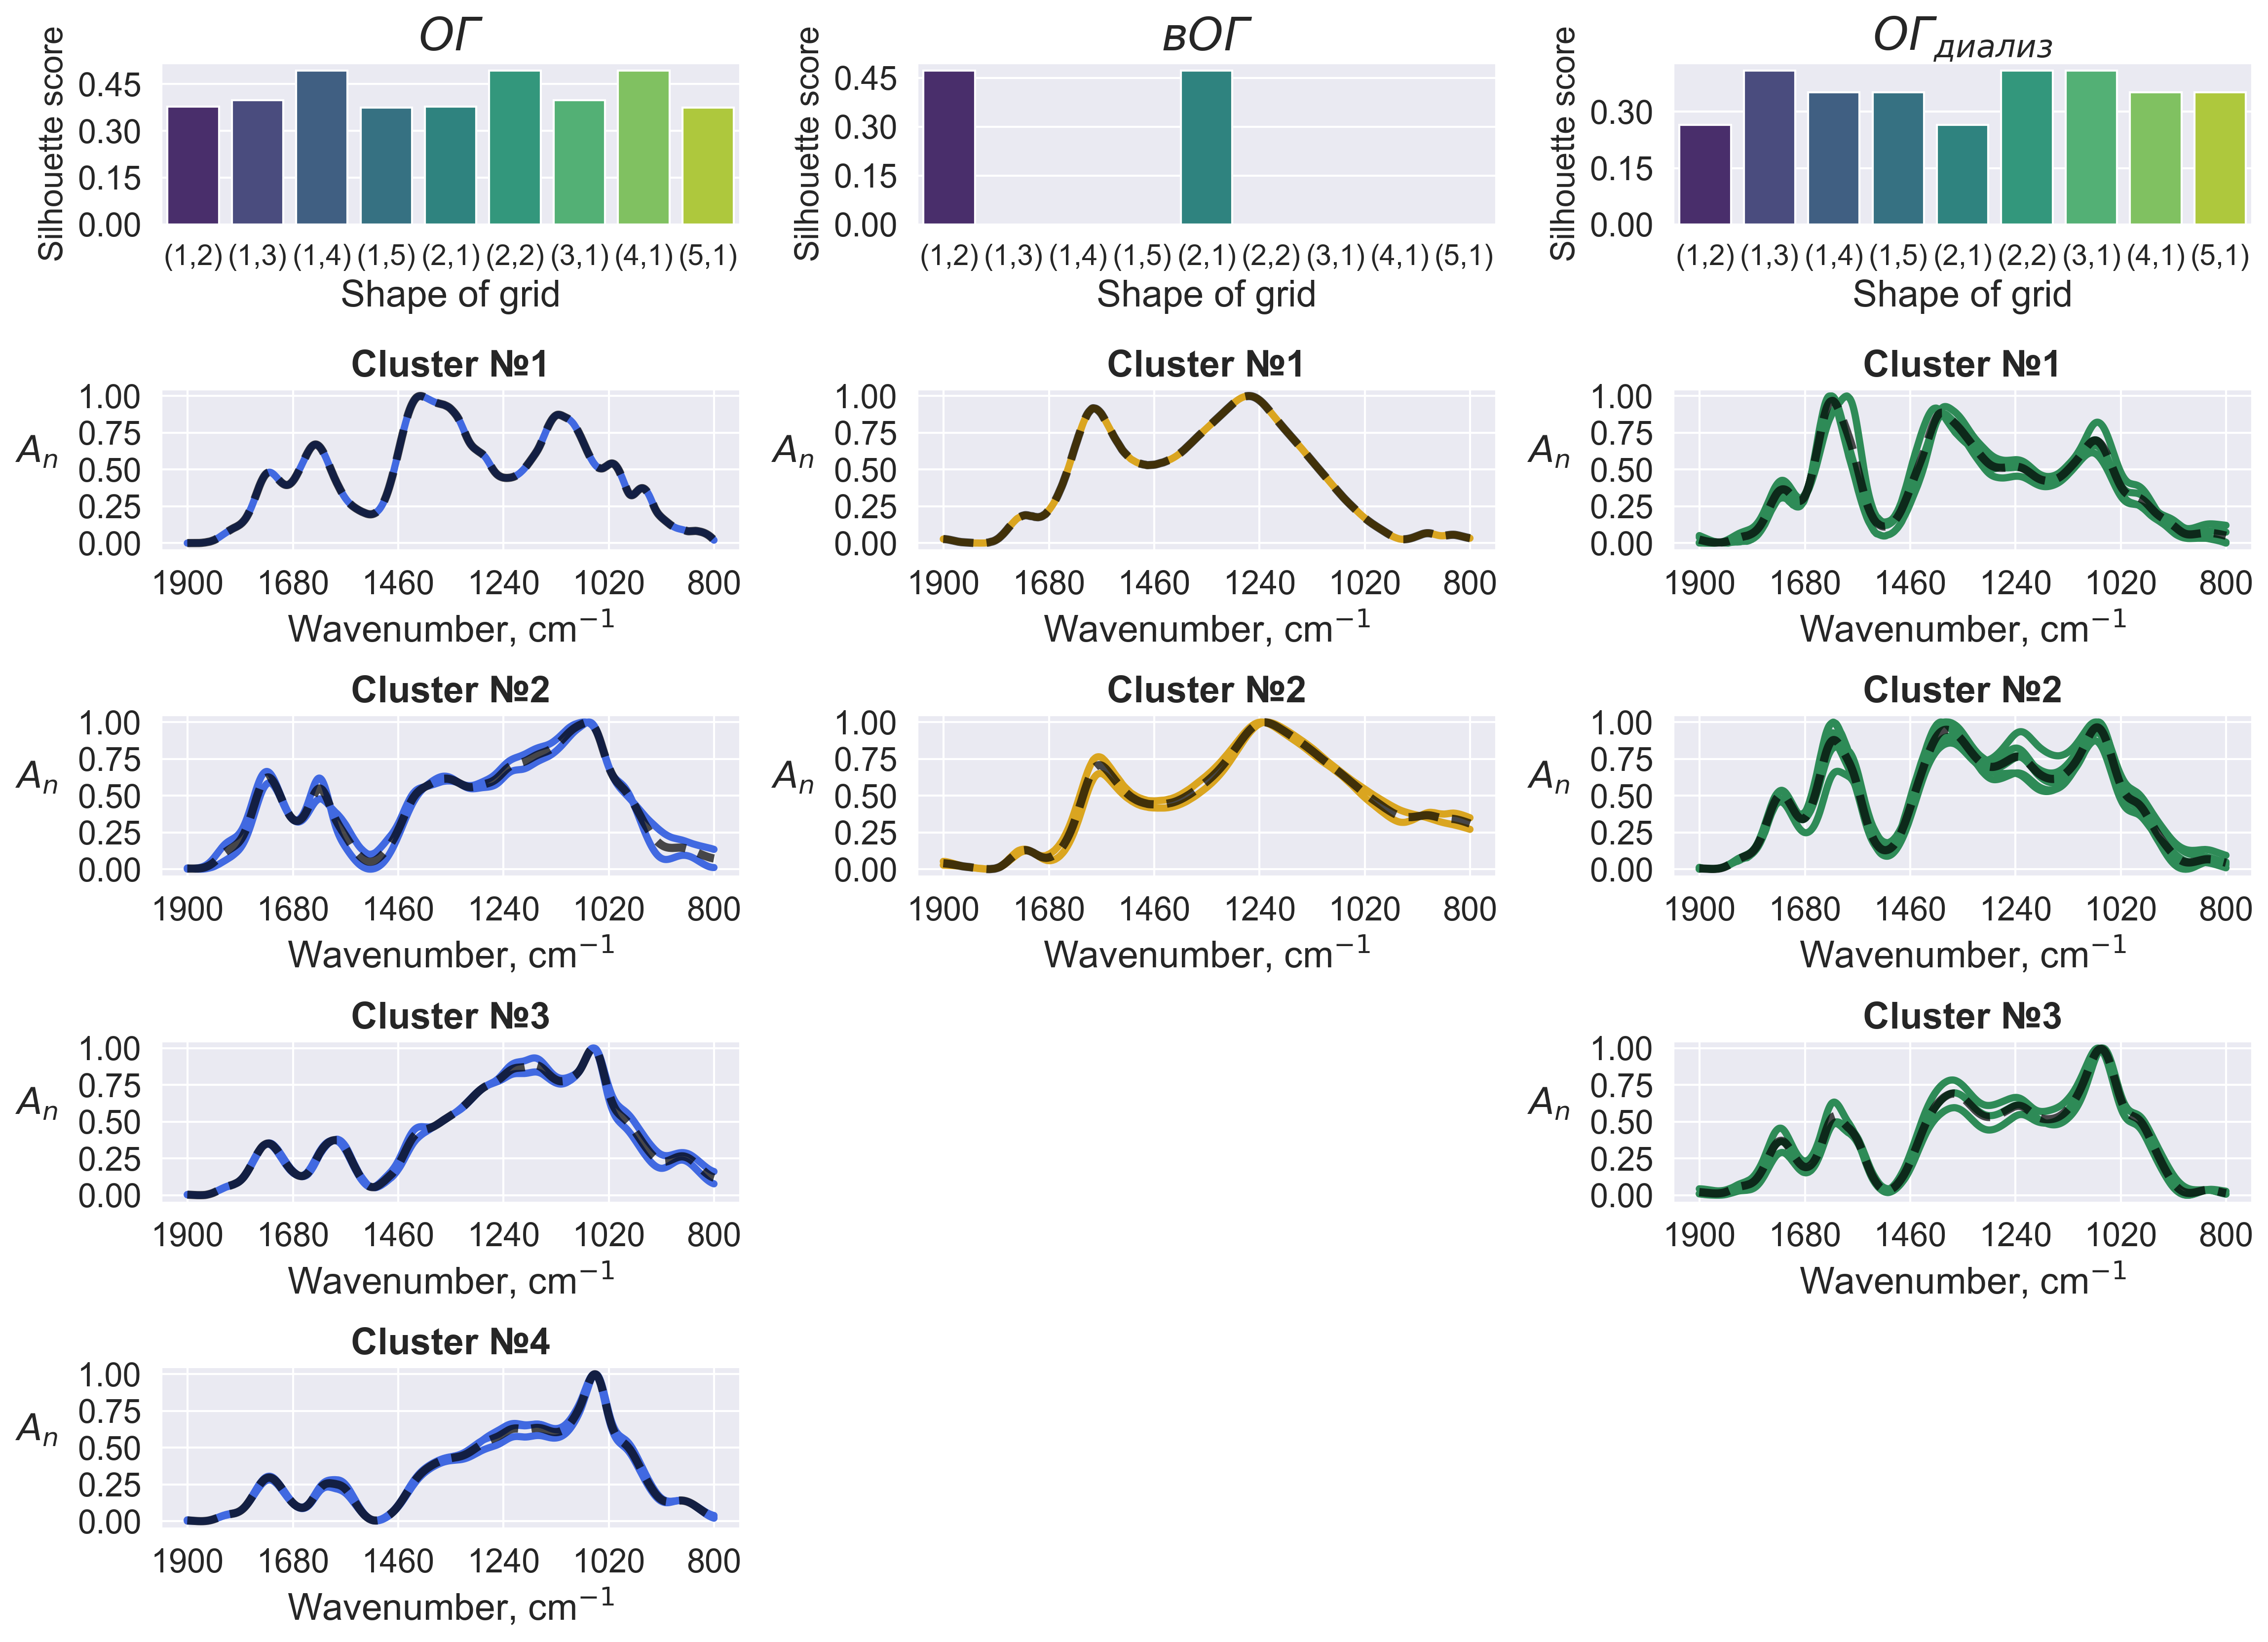

In [17]:
sns.set_theme()

max_clusters = max([d[3][0] * d[3][1] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(15.5, 2.25 * fig_rows), dpi=300, constrained_layout=True)

for i, (label, dataset, color, shape) in enumerate(datasets):
    analyzer = SomStructureAnalysis(dataset)

    analyzer.fit_transform_som(shape=shape, num_iteration=25_000)
    
    analyzer.get_metrics_visualization(max_n_clusters=max_n_clusters, ax=axes[0, i], refit=False)
    
    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE)
    axes[0, i].set_xlabel(f'Shape of grid', fontsize=FONT_SIZE_XLABEL)
    axes[0, i].set_ylabel(f'Silhouette score', fontsize=FONT_SIZE_YLABEL-2)
    axes[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.15))

    sub_axes = axes[1:analyzer.n_clusters+1, i]
    
    analyzer.get_spectra_clusters_visualization(wavenumber=wavenumber, axes=sub_axes, color=color)

    for i, ax in enumerate(sub_axes):
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
        ax.set_title(f'Cluster №{i+1}', fontsize=FONT_SIZE_TITLE-4, fontweight='bold')
        ax.set_xlabel('Wavenumber, cm$^{-1}$', fontsize=FONT_SIZE_XLABEL)

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3][0] * datasets[i][3][1] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig(f'{path_to_save}/adhoc_clustering_results.png', dpi=600)

plt.show()